In [1]:
import numpy 
from scipy.io import wavfile
from pathlib import Path
import librosa
import librosa.display
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchaudio
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F

In [2]:
# Load wav file form disk
audio_path = Path('./samples/preset_0.wav')
audio = wavfile.read(audio_path)[1]

In [3]:
print(audio)

[[-7.9486648e-09 -7.9486648e-09]
 [-1.4478941e-07 -1.4478941e-07]
 [-2.8275562e-07 -2.8275562e-07]
 ...
 [ 5.5927155e-04  4.5905111e-04]
 [ 1.6647105e-03 -1.7799288e-03]
 [ 2.0489185e-03 -3.6279159e-03]]


In [4]:
def generate_spectrogram(audio_path):
    y, sr = librosa.load(audio_path)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    # display
    fig, ax = plt.subplots()
    img = librosa.display.specshow(librosa.power_to_db(spectrogram, ref=numpy.max), y_axis='mel', x_axis='time', ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel spectrogram display')
    plt.show()

    # Save to disk
    print(spectrogram)
    print(spectrogram.shape)

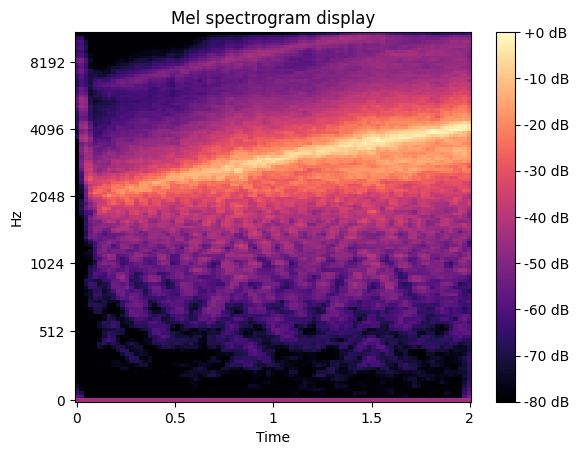

[[2.60503202e-06 4.09315817e-06 3.35873983e-06 ... 3.34795800e-06
  3.88214949e-06 4.19702928e-06]
 [1.64701532e-07 6.23522993e-08 7.53591634e-11 ... 9.75114212e-10
  7.43500408e-08 4.47128656e-07]
 [3.22054348e-08 9.41109057e-09 1.24650585e-11 ... 1.44650936e-09
  2.80382704e-08 1.77149133e-07]
 ...
 [2.05067643e-08 2.76137957e-08 2.13589879e-09 ... 1.34702975e-06
  1.46157197e-06 9.67772053e-07]
 [4.45010295e-09 5.97300343e-09 6.11716233e-10 ... 4.73962700e-07
  4.73573522e-07 5.75899662e-07]
 [3.27967237e-10 4.21430196e-10 5.18179041e-11 ... 3.91267285e-08
  2.43632119e-08 4.73826418e-08]]
(128, 87)


In [5]:
generate_spectrogram(audio_path)

In [33]:
class AudioDS(Dataset):
    def __init__(self, presets_csv_path):
        self.presets = pd.read_csv(presets_csv_path)
    
    def __len__(self):
        return len(self.presets)
    
    def __getitem__(self, idx):
        preset = self.presets.iloc[idx]
        audio_path = Path(f'./samples/{preset[0]}.wav')
        y, sr = librosa.load(audio_path)
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
        # Add channel dimension
        spectrogram = numpy.expand_dims(spectrogram, axis=0)
        # Transform to tensors
        spectrogram = torch.tensor(spectrogram)
        preset = torch.tensor(preset[1:-1])
        return spectrogram, preset

In [34]:
dataset = AudioDS('presets.csv')
num_train = int(0.8 * len(dataset))
num_val = len(dataset) - num_train
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [num_train, num_val])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=1, shuffle=True)

In [37]:
# Basic CNN. Credit: https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5
class AudioClassifier(nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=88)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cuda', index=0)

In [51]:
def train(model, train_dl, num_epochs):
    # Loss Function, Optimizer and Scheduler
    # because this is regression, use mse
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                    steps_per_epoch=int(len(train_dl)),
                                                    epochs=num_epochs,
                                                    anneal_strategy='linear')

    # Repeat for each epoch
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        # Repeat for each batch in the training set
        for i, data in enumerate(train_dl):
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Zero the parameter gradients
            optimizer.zero_grad()

            # print('inputs: ', inputs)
            # print('inputs shape: ', inputs.shape) # 1, 1, 128, 87
            # print('labels: ', labels) 
            # print('labels shape: ', labels.shape) # 1, 88

            # forward + backward + optimize
            outputs = model(inputs)

            # print('outputs: ', outputs)
            # print('outputs shape: ', outputs.shape) # 1, 10
        
            outputs.float()
            labels = labels.float()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

            if i % 10 == 0:    # print every 10 mini-batches
               print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
        
        # Print stats at the end of the epoch
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction/total_prediction
        print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

    print('Finished Training')
  
num_epochs=20
train(myModel, train_loader, num_epochs)

C:\Users\jayor\AppData\Local\Temp\ipykernel_6188\799138928.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  audio_path = Path(f'./samples/{preset[0]}.wav')
C:\Users\jayor\AppData\Local\Temp\ipykernel_6188\799138928.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preset = torch.tensor(preset[1:-1])


[1,     1] loss: 0.008
[1,    11] loss: 0.096
[1,    21] loss: 0.179
[1,    31] loss: 0.260
[1,    41] loss: 0.341
[1,    51] loss: 0.429
[1,    61] loss: 0.515
[1,    71] loss: 0.595
[1,    81] loss: 0.678
[1,    91] loss: 0.758
[1,   101] loss: 0.840
[1,   111] loss: 0.930
[1,   121] loss: 1.013
[1,   131] loss: 1.095
[1,   141] loss: 1.175
[1,   151] loss: 1.264
[1,   161] loss: 1.346
[1,   171] loss: 1.429
[1,   181] loss: 1.510
[1,   191] loss: 1.596
[1,   201] loss: 1.674
[1,   211] loss: 1.759
[1,   221] loss: 1.843
[1,   231] loss: 1.927
Epoch: 0, Loss: 0.08, Accuracy: 0.00
[2,     1] loss: 0.009
[2,    11] loss: 0.093
[2,    21] loss: 0.176
[2,    31] loss: 0.263
[2,    41] loss: 0.347
[2,    51] loss: 0.437
[2,    61] loss: 0.518
[2,    71] loss: 0.603
[2,    81] loss: 0.687
[2,    91] loss: 0.771
[2,   101] loss: 0.852
[2,   111] loss: 0.934
[2,   121] loss: 1.019
[2,   131] loss: 1.100
[2,   141] loss: 1.186
[2,   151] loss: 1.268
[2,   161] loss: 1.352
[2,   171] loss: 1.4